<a href="https://colab.research.google.com/github/Ujustwaite/ml1/blob/master/Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 2: Classification Using New York City Fire Department Data:**


### Team: Aditya Garapati, Chase Henderson, Brian Waite, Carl Walenciak

### Date: 10/24/2019




# General Description:

## Business Understanding:

This is a continuation of the analysis of the Fire Department of New York City (FDNY) data describing fire incidents in support of the New York Fire Incident Reporting System (NYFIRS). Prior to and during our initial data preparation, we identified a number of analytic questions that could be of interest to fire resource planners. 

New York City uses a series of alarm codes to identify the severity of a fire and the associated response. These alarm codes are described at the following web locations: 

http://www.fdnewyork.com/aa.asp

https://en.wikipedia.org/wiki/New_York_City_Fire_Department#Radio_and_bell_code_signals


## Problem Statement 1: Predicting High-Alarm vs. Low-Alarm Fires



Build a classification model that can **predict whether a fire constitutes a severe, high level incident, or a less-severe fire** based on parameters contained in the available data set. 

By building this classification model, we seek not only to identify the level of incidents based on parameters, but also to identify factors that contribute to an incident being classified as a high-level / low-level incident in order to aid planners in their future decision making process. 

#### Problem 1 Approach: 

This analysis builds upon the work previously submitted in the Mini-Lab assignment. In additon to using logistic regression and support vector machine models, we expand our analysis to include a Random Forest Classifier. With each we provide appropriate interpretation of the model parameters to understand the factors that contribute to the classification decision. 

For those models (Logistic Regression and SVM) that were used in the Mini-Lab, we will carry forward the optimization that we performed to gain best performance. This is typically the model with the best performance after performing a GridSearch on a variety of model parameters. Those "best fit" model parameters will be carried forward and run once here. 

For models not previously included in other assignments, the full GridSearch / optimization process is displayed and model performance evaluation according to selected criteria is described. 

## Problem Statement 2: Predicting Total Incident Duration of Fire Events


The second problem was not a part of the mini-lab assignment and expands our analysis to include the new **prediction of the `total incident duration` value.** Based on the features given, we seek to provide a model for predicting how long an incident might last given the parameters. This can possibly help immediate decision making about how to balance resources and the ability for fire department leadership to shorten the length of incidents by adjusting future responses.

#### Problem 2 Approach: 

In our analysis below, we will employ a number of linear regression models built using a variety of features and parameters in an attempt to identify the best possible model providing the most reliable predictions. Feature selection , interaction terms, and other techniques will be applied to both maximize the model and align as closely to the assumptions required for linear regression as possible. 

In addition to the multiple linear regression techniques, we explore the use of a Random Forest based regressor that is capable of leveraging random forest techniques like those we studied in the classification portion of the course with linear regression techniques. 

# Data Preparation: 

## Data Description: 

A robust description of the data has been previously provided along with an associated Exploratory Data Analysis. That information is available here for reference: https://colab.research.google.com/github/Ujustwaite/ml1/blob/master/Playing_With_Fire.ipynb

## Data Cleaning: 

To optimize this analysis, we need to do some additional transformation of the data and some leftover housekeeping from our EDA. This includes: 

* Conversion of the presence of the Automatic Extinguisher System to either "not present = 0" or "present = 1". 

* Conversion of the presence of a fire dector to either "not present = 0" or "present = 1". 

* Conversion of the presence of a standpipe system to "not present = 0" or "present = 1". 

* Filling of missing `total_incident_duration` values with the mean value. **Note that this process has been updated to take place after the separation of the Train / Test data in order to not pollute the model with advance knowledge of the Test data set.**

* Correction of two incorrect zip code values. 

* Dropping of categorical fields that are freely input by the user and are unusable for analysis or are not consistently used in a meaningful sense for this problem. 

In [22]:
!pip install category_encoders

In [0]:
#Imports Section
import category_encoders as ce
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

#Read in the data output from EDA step
final_df = pd.read_pickle('final_df.pkl')


In [0]:
#DATA CLEANING BLOCK

#AES presence update
final_df.loc[final_df['aes_presence_desc'] == '1 - Present', 'aes_presence_desc'] = 1
final_df.loc[final_df['aes_presence_desc'] != 1, 'aes_presence_desc'] = 0

#Smoke Detector presence update
final_df.loc[final_df['detector_presence_desc'] == '1 - Present', 'detector_presence_desc'] = 1
final_df.loc[final_df['detector_presence_desc'] != 1, 'detector_presence_desc'] = 0

#Standpipe presence update
final_df.loc[final_df['standpipe_sys_present_flag'] == '1', 'standpipe_sys_present_flag'] = 1
final_df.loc[final_df['standpipe_sys_present_flag'] != 1, 'standpipe_sys_present_flag'] = 0

#Replacement of missing zip codes
#Identified values using google maps and intersection information
final_df.at[18695, 'zip_code'] = '11103'
final_df.at[18760, 'zip_code'] = '11357'

#Drop the categorical columns determined to be unusable
final_df = final_df.drop(columns = ['fire_spread_desc','floor','story_fire_origin_count'])

#Drop the remaining 19 values that are missing the highest level alarm description
final_df.dropna(inplace = True)

### Problem 1 Data Preparation:  Define and prepare your class variables.

Because the target variable is not currently in the data set, we must construct it with the existing available data set. 

Here we will take the existing feature, `highest_level_desc` that defines the level of alarm raised for each incident in the data set and convert it to a binary value. The values contained in the data set are: 

In [25]:
final_df.highest_level_desc.unique()

array(['11 - First Alarm', '75 - All Hands Working',
       '1 - More than initial alarm, less than Signal 7-5',
       '7 - Signal 7-5', '2 - 2nd alarm', '0 - Initial alarm',
       '22 - Second Alarm', '5 - 5th alarm', '4 - 4th alarm',
       '3 - 3rd alarm', '55 - Fifth Alarm', '33 - Third Alarm',
       '44 - Fourth Alarm'], dtype=object)

As you might expect, the majority of the events occuring throughout the city are low-level fires.

In [26]:
grouped = final_df.groupby(['highest_level_desc'])
grouped.count().im_incident_key

highest_level_desc
0 - Initial alarm                                       19
1 - More than initial alarm, less than Signal 7-5    12963
11 - First Alarm                                     11873
2 - 2nd alarm                                           53
22 - Second Alarm                                       47
3 - 3rd alarm                                           13
33 - Third Alarm                                        11
4 - 4th alarm                                            4
44 - Fourth Alarm                                        5
5 - 5th alarm                                            5
55 - Fifth Alarm                                         5
7 - Signal 7-5                                         701
75 - All Hands Working                                 621
Name: im_incident_key, dtype: int64

This means we have the potential for the data of "in class" vs. "out of class" to be highly imbalanced. We'll address this later in our analysis. For our analysis, we determined based on the definitions of the alarms in the references provided and on our initial EDA, that a severe fire is level 2 including Signal 7 / Signal 75, which are not truly 2 alarm or higher, but help to balance the in class data set. 

In [0]:
#Split the alarm code off the front of the description
new = final_df["highest_level_desc"].str.split(" ", n = 1, expand = True) 
#Convert to integer
new[0] = new[0].astype('int32')
#Map the classifications according to alarm code
desc = {2: 1,22: 1, 3:1,33:1,4:1,44:1,5:1,55:1,0:0,1:0,11:0,7:1,75:1,} 
final_df['FireLevel'] = [desc[item] for item in new[0]] 

In [28]:
#Number of in class records
final_df.FireLevel.sum()

1465

In [29]:
#Total number of records
final_df.FireLevel.shape[0]

26320

Our target variable is now contained in the data frame as `FireLevel`. As we can see, there are 1,467 in class values out of the total 26,322 records. Approximately 5.6 percent. We will monitor and adjust for this imbalance throughout our analysis. 

## Encoding of Categorical Predictors

In order to ensure the categorical values are providing balanced contributions to the model, we leverage one-hot encoding. This significantly increases the number of features. 

In [0]:
#Encode borough description
label = ce.OneHotEncoder(use_cat_names=True)
borough_label = label.fit_transform(final_df[['borough_desc']])

#Encode incident type
label = ce.OneHotEncoder(use_cat_names=True)
incident_type_label = label.fit_transform(final_df[['incident_type_desc']])

#Encode actiontaken 1 label -- the primary action taken by units onscene
label = ce.OneHotEncoder(use_cat_names=True)
action_taken_1_label = label.fit_transform(final_df[['action_taken1_desc']])

#Encode highest level desc for Problem 2
label = ce.OneHotEncoder(use_cat_names=True)
highest_level_label = label.fit_transform(final_df[['highest_level_desc']])

## Drop Columns Not to be Used in Analysis

### Problem 1 drops

A number of the columns in the dataframe are now duplicative of the encoded columns or are redundant / not useful. Things like zip_code, street_highway, and nearest_intersection are already captured in lat/long that we'll retain. We have translated Date Time related information into the Total Incident Duration and will not use that here. 

In [0]:
#drop the unnecessary columns
model_df = final_df.drop(columns = ['action_taken1_desc', 'action_taken2_desc', 'action_taken3_desc', 'borough_desc','fire_box', 'highest_level_desc', 'im_incident_key', 'incident_date_time', 'incident_type_desc', 'last_unit_cleared_date_time', 'property_use_desc', 'street_highway', 'zip_code', 'nearest_intersection','incident_code', 'incident_desc', 'DATE','FireLevel'])

In [0]:
#concatenate the encoded columns
model_df = pd.concat([model_df,incident_type_label, action_taken_1_label, borough_label], axis = 1)

In [0]:
#Move the target value to the end of the dataframe and rename as target
model_df['target'] = model_df['FireLevel']
model_df = model_df.drop(columns = 'FireLevel')

Also during the Mini-Lab assignment, we identified that the `units_onscene` and `total_incident_duration` were essentially representing the same value as our "to be predicted" target variable. They were therefore skewing the model to be accurate when in fact it was not really "predicting" anything, and so we made the determination to leave them out of the Problem 1 analysis. 

In [0]:
#Drop columns that violate the independence assumption. 
model_df = model_df.drop(columns = ['total_incident_duration', 'units_onscene'])

### Problem 2 Drops: Total Incident Duration regression

In [0]:
#drop the unnecessary columns
model_2_df = final_df.drop(columns = ['action_taken1_desc', 'action_taken2_desc', 'action_taken3_desc', 'borough_desc','fire_box', 'highest_level_desc', 'im_incident_key', 'incident_date_time', 'incident_type_desc', 'last_unit_cleared_date_time', 'property_use_desc', 'street_highway', 'zip_code', 'nearest_intersection','incident_code', 'incident_desc', 'DATE'])

In [0]:
#concatenate the encoded columns
model_2_df = pd.concat([model_2_df,incident_type_label, action_taken_1_label, borough_label, highest_level_label], axis = 1)

In [0]:
#Move the target value to the end of the dataframe and rename as target
model_2_df['target'] = model_2_df['total_incident_duration']
model_2_df = model_2_df.drop(columns = 'total_incident_duration')

threshold = 15000
model_2_df = model_2_df.loc[model_2_df['target'] <= threshold]

## Create Train / Test Split

In order to prepare for the analysis, we will use a shuffled 80/20 Train-Test split with stratification due to the small number of representative samples of the "in class" variables described above. The data is randomly selected for inclusion in either split, with a set seed to enable replication of results, but is stratified to ensure representation in both the train and test sets of the in class records. 

In [0]:
#Problem 1 data
X_p1_train, X_p1_test, y_p1_train, y_p1_test = train_test_split(model_df.iloc[:,0:97], model_df.iloc[:,97], test_size=0.20, random_state=42, shuffle = True, stratify = model_df.iloc[:,97])

#Problem2 data
X_p2_train, X_p2_test, y_p2_train, y_p2_test = train_test_split(model_2_df.iloc[:,0:112], model_2_df.iloc[:,112], test_size=0.20, random_state=42, shuffle = True)

### Problem 2: Imputation of the `total_incident_duration` feature: 

One error we made in the Mini-Lab was to pollute the training data by imputing on the entire data set prior to splitting into train and test. The below corrects this by imputing the 'total_incident_duration' on both the train and test sets separately using their respective mean values independently. 

This value is not used in problem 1, so is only applied to the problem 2 data set. Remember that `total_incident_duration` has been renamed as `target` for clarity in Problem 2 and is the only value in the y vector.  

In [0]:
#Total Incident Duration imputation
y_p2_train.fillna((y_p2_train.mean()), inplace = True)
y_p2_test.fillna((y_p2_test.mean()), inplace = True)


### Scaling

Also, to properly evaluate the relative importance of features in some of the models, we create a scaled version of the data. This is particularly useful when comparing the feature importance in the logistic regression and to properly execute the svm. Scales are built on the training data and applied to the test data in order to maintain the same relative importance / values. 

In [0]:
#Recreate the scaled data set with dropped variables. 

scl_obj = StandardScaler()
scl_obj.fit(X_p1_train) 

X_p1_train_scaled = scl_obj.transform(X_p1_train) # apply to training
X_p1_test_scaled = scl_obj.transform(X_p1_test) # applyto the test set

### Upsampling to obtain balanced records

To address the large imbalance in the data set, we successfully implemented code to up-sample the "in-class" records in the data set to be equally present in the data set with "out of class" records. 

In [38]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_p1_train, y_p1_train], axis=1)

# separate minority and majority classes
not_severe = X[X.target==0]
severe = X[X.target==1]

# upsample minority
severe_upsampled = resample(severe, replace=True, # sample with replacement
                          n_samples=len(not_severe), # match number in majority class
                          random_state=123) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_severe, severe_upsampled])

# check new class counts
upsampled.target.value_counts()

1    19884
0    19884
Name: target, dtype: int64

This same process can be used by using the class_weight = 'balanced' flag when creating the model objects, but we wanted to execute the up-sampling to understand the process for doing so. 

Reference: https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

### Describe the final dataset that is used for classification/regression.

Recall that during the initial phases of our research, we identified the need for a number of engineered features. These remain included in the data set and are as follows: 



*   `Distance_To_Nearest_Station`: An engineered feature derived by measuring the distance between the nearest firehouse location and the firebox. Straight line distance using Mercator projection.	
*   `response_time`:	An engineered feature derived from arrival time of first units on scene and the time the incident occured.

Note also that we expanded the data set with location information about the fire boxes and weather related information for NYC on the date of the incident.

*   `LONG`	Longitude of the firebox location where the incident occured.
*   `LAT`  	Latitude of the firebox location where the incident occured.
*   `PRCP`:	Precipitation amount as measured in Central Park on date of the incident.
*   `SNOW`	Amount of precipitation that was recorded as snowfall.
*   `SNWD`	Amount of snow accumulation reported on the day of the incident.

The final data set has the following parameters: 

In [0]:
#Number of features
X_p1_train.shape

#(Number of Records, Number of Features w/One Hot Encoding)

In [40]:
#Number of in-class in train data
y_p1_train.sum()

1172

In [41]:
#Number of records in test set
X_p1_test.shape

(5264, 97)

In [42]:
#Number of in-class in test set
y_p1_test.sum()

293

# Modeling and Evaluation

## Evaluation Metrics and Reasoning: 

#### Problem 1: Classification of Fire Severity

Evaluation of classification models will be through the use of confusion matrix based statistics including accuracy, precision and recall. Because of the small occurrence rate of high severity fires, we found accuracy to be an unreliable indicator of the performance of our model in and of itself. Therefore, we prefer models that balance the performance across these multiple indicators. 

In addition, the Area Under the Curve (AUC) assessments using Receiver Operating Characteristic (ROC) curve analysis is used to compare model performance and to evaluate the performance of any final selected model.

For our Random Forest model, we can also explore the probability with which the model predicted the values and the distribution to evaluate the performance. 


#### Problem 2: Prediction of Total Incident Duration

In order to evaluate our regression models, we will leverage some of the statistical evaluation techniques. This will include comparison plots of the expected vs. predicted values, residual plots to determine if we can meet the assumptions of linear regression modeling, and metrics such as the R-squared value to compare various iterations of our models for performance. 

## Splitting Procedure for Data

For both problems, we are splitting the data in an 80/20 split with shuffled assignment and stratification to preserve the proportion of in-class / out-of-class values in both the train / test sets. When running the Grid Search on the models to optimize parameters, we use 3-fold cross validation. 

We understand that 3-fold cross validation is less preferable than 5 or 10 fold that are more standard. However, due to the computing resources available, time constraints the team is operating under, the number of model types being run, and the need to meet a specific deadline, 3-fold cv was selected in order to demonstrate the improvement gained, while still producing results in a reasonable time. 

Stratification is required due to the small number of in-class exemplars, particularly for Problem 1. The initial shuffling ensures semi-random assignment (with stratification exception) to train / test sets and the in model use of cross validation ensures an optimized representation of the data. 

## Problem 1: Modeling and Analysis

In building a predictive classifier to determine whether a fire is "severe" or "not severe", we used both logistic regression and a support vector machine model in the Mini-Lab. This analysis builds on the work that was done there to expand to additional models and to further evaluate the factors that contribute to a fire's severity and the implied business insights that can be gained. 

The logistic regression and support vector models shown below are the result of optimization processes that used Grid Search methods that are documented in the Mini-lab assignment. The final models are displayed. 

### Logistic Regression: 

Leveraging our previous mini-lab work, we can fit a logistic regression model with our previously identified optimal parameters. 

In [0]:
#Fit the model using the final selected parameters. 
lr_clf = LogisticRegression(fit_intercept = True, intercept_scaling = 1, solver = 'newton-cg', max_iter = 500, penalty='l2', C=0.001, tol = 0.0001, class_weight='balanced')
lr_clf.fit(X_p1_train_scaled,y_p1_train)  # train object
y_hat = lr_clf.predict(X_p1_test_scaled)

In [52]:
# print the accuracy and confusion matrix 
print("accuracy", mt.accuracy_score(y_p1_test,y_hat)) 
print("precision", mt.precision_score(y_p1_test,y_hat))
print("recall", mt.recall_score(y_p1_test,y_hat))
print("confusion matrix\n",mt.confusion_matrix(y_p1_test,y_hat))


accuracy 0.9517477203647416
precision 0.5383104125736738
recall 0.9351535836177475
confusion matrix
 [[4736  235]
 [  19  274]]


Our accuracy and recall both perform well, but our model suffers a bit in the area of precision. Accuracy is likely over-inflated due to the imbalance in the data set even though we have sought to compensate for this by upsampling the positive class. If precision is an indication of the probability of the model to predict correct values, then we may need to continue to seek improvement here. This could mean we need to seek additional data or additional features within the data we have to continue to improve. 

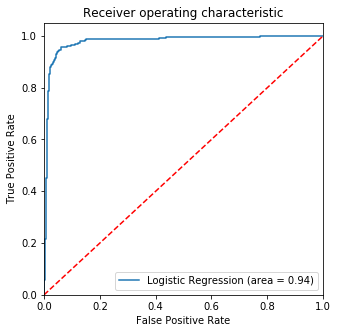

In [47]:
# Produce a ROC curve
matplotlib.rcParams['figure.figsize'] = (5.0, 5.0)
logit_roc_auc = mt.roc_auc_score(y_p1_test, lr_clf.predict(X_p1_test_scaled))
fpr, tpr, thresholds = mt.roc_curve(y_p1_test, lr_clf.predict_proba(X_p1_test_scaled)[:,1])
#logit_auc = mt.auc(fpr,tpr)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

The above ROC curve demonstrates a strong model with an AUC of 0.94. 

## Interpreting the Logistic Regression Model: 

One of the benefits of the logistic regression model is its ease of interpretation. Once we scaled the data being entered into the model, we are able to compare the values against each other and identify contributing factors to whether a fire is more or less severe. 

**Building and structure fires are the most severe.**

The greatest contributor to whether a fire is classified as severe or not is whether the incident type is reported as a building fire. In addition, fires in a structure other than a building is has high relative influence. Counterintuitively, the presence of a smoke detector is correlated with a more severe fire in the model, but this is likely due to the fact that detectors are primarily placed inside of structures -- which as we see are at greatest risk.

**Contained fires, cooking fires in their original container, outdoor fires, or vehicle fires are generall not severe.**

Cooking fires contained to their container, outdoor rubbish or garbage fires, and vehicle fires are the strongest contributors to a fire being classified as not severe. This makes sense as their contained or isolated nature would likely make them more difficult to spread and become a more dynamic fire.

**Geographic boroughs within the city do have an impact on fire severity.**

Fires occuring in Staten Island have the greatest risk of being classified as severe with Queens also being at significant risk. Conversely, Manhattan and the Bronx are more correlated with less severe fires. Being located in Brooklyn appeared neutral.

This differentiation could be the result of fire department density in those areas or the types of structures present in either. Queens and Staten Island are more likely to have residential structures that may not be equipped with sprinkler systems or robust alarms. It might be worthwhile evaluating interaction terms between location and some of these other attributes in further modeling attempts.

LATITUDE and LONGITUDE also contributed to the model in a manner generally consistent with this. Increased LATITUDE (or more Northern boroughs) were generally at less risk (Manhattan and the Bronx are the Northernmost boroughs). It makes sense that LONGITUDE's contribution is less because many of the boroughs share the same relative longitude.

Increased distance to the nearest fire station also has some measurable contribution to increasing whether a fire will be classified as severe. Greater distance is a greater risk of severity and is likely an indication of the amount of time the fire has to develop.

**Action taken may be more informative about future resource allocation**

The action taken category is probably not a strong predictor, but does offer insight into how resources are used in both severe and non-severe fires. Not surprisingly, during severe fires the action taken was highly correlated with extinguishing actions, establishment of control centers, and deployment of hoses in support of a precautionary effort.

On the other hand, actions involved in non-severe fires included investigations, securing of the surrounding area, or finding the fire "out on arrival". Additional trend analysis on this data may offer some insight as to the level of unit that may need to be incorporated into the force or the training areas that teams need to focus on.

**Increased precipitation is associated with less severe fires.**

Although it may seem obvious, the model confirms the fact that both rain precipiation and snow are associated with decreased fire severity. Interestingly, increased snow depth (SNWD in our model) indicating actually accumulated snow is a relatively strong indicator of decreased fire severity. Perhaps this is due to the ability of melting snow to aid in putting out fires.

In [51]:
# Sort the features by weight and display
zip_vars = zip(lr_clf.coef_.T,X_p1_test.columns) 
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has scaled weight of', coef[0]) 

incident_type_desc_113 - Cooking fire, confined to container has scaled weight of -0.6078372888188093
incident_type_desc_151 - Outside rubbish, trash or waste fire has scaled weight of -0.2011376663503909
incident_type_desc_131 - Passenger vehicle fire has scaled weight of -0.15426890529043993
response_time has scaled weight of -0.14902876998945447
action_taken1_desc_21 - Search has scaled weight of -0.13078199175422262
action_taken1_desc_53 - Evacuate area has scaled weight of -0.1220532390172842
action_taken1_desc_86 - Investigate has scaled weight of -0.10059047366813614
action_taken1_desc_215 - Check for extension has scaled weight of -0.08214431283431704
LAT has scaled weight of -0.08134114890222817
borough_desc_1 - Manhattan has scaled weight of -0.07850818391078114
action_taken1_desc_87 - Investigate fire out on arrival has scaled weight of -0.06874468622743989
incident_type_desc_132 - Road freight or transport vehicle fire has scaled weight of -0.054742147026858666
PRCP has sca

Both the coefficients and the feature importance plot below demonstrate the findings we describe above. We can see that Building Fire stands out above the rest and Cooking Fires that remain confined to the container they originate in often are less severe. 

Text(0.5, 1.0, 'Feature importance')

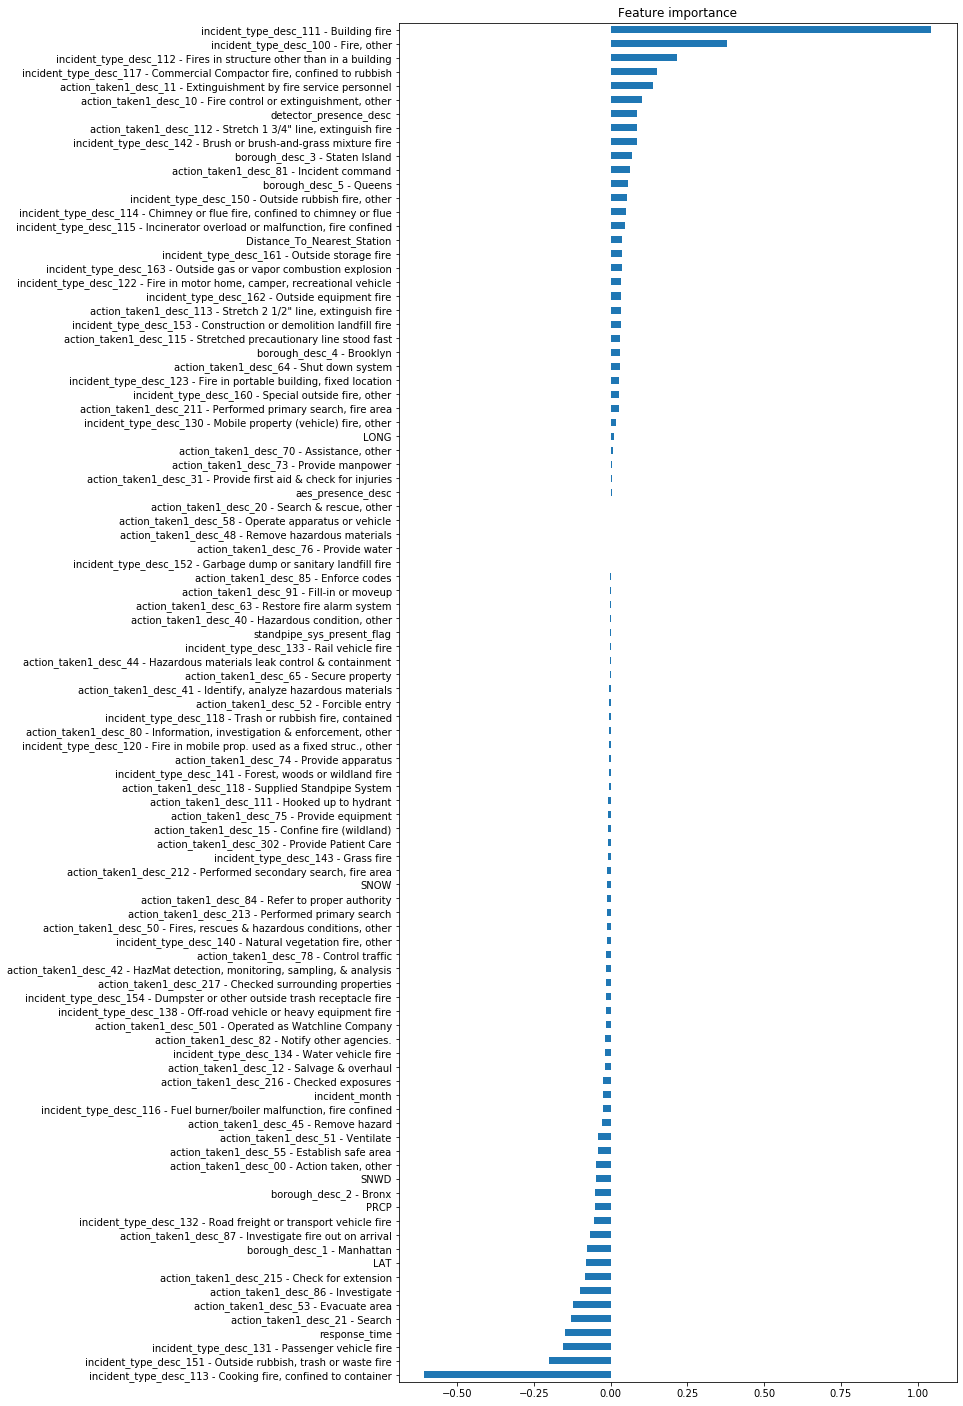

In [49]:
# Examine the feature importance by using the coefficients of the LR model. 
coef = pd.Series(lr_clf.coef_[0], index = X_p1_train.columns)
# Sort the coefficients for easy interpretation
imp_coef = coef.sort_values()
# Expand the plot to display nicely. 
matplotlib.rcParams['figure.figsize'] = (10.0, 25.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance")

### Support Vector Machine

This SVM model again draws on the previous work from the mini-lab. The parameters are the result of a Grid Search and represent the most balanced model that we were able to obtain.

In [0]:
#Fit SVM with the optimized parameters
svm_clf = SVC(C=0.001, cache_size=200, class_weight='balanced',
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.01, kernel='sigmoid', max_iter=-1,
                     random_state=None, shrinking=True,
                     tol=0.001, verbose=False, probability = True)
# fit using the scaled data set
svm_clf.fit(X_p1_train_scaled, y_p1_train)

y_hat_svm = svm_clf.predict(X_p1_test_scaled)

In [54]:
print("accuracy", mt.accuracy_score(y_p1_test,y_hat_svm)) 
print("precision", mt.precision_score(y_p1_test,y_hat_svm))
print("recall", mt.recall_score(y_p1_test,y_hat_svm))
print("confusion matrix\n",mt.confusion_matrix(y_p1_test,y_hat_svm))

accuracy 0.9741641337386018
precision 0.7315634218289085
recall 0.8464163822525598
confusion matrix
 [[4880   91]
 [  45  248]]


We can see here that our precision metric is significantly improved, while the recall value takes a slight hit when compared to the logistic regression model above. That said, this model is much more likely to represent the real performance and predictive ability of our model. The balance of precision and recall makes us much more confident that we're able to provide useful insights to the decision makers. 

Perhaps this model would be more appropriate to employ in an automated work flow whereas the logistic regression provides a clearly interpretable model for the decision makers to use to understand the factors at play in the fires they are responding to. 

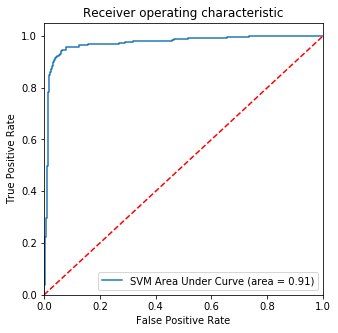

In [55]:
# Produce a ROC curve of this optimized model
matplotlib.rcParams['figure.figsize'] = (5.0, 5.0)
svm_roc_auc = mt.roc_auc_score(y_p1_test, svm_clf.predict(X_p1_test_scaled))
fpr, tpr, thresholds = mt.roc_curve(y_p1_test, svm_clf.predict_proba(X_p1_test_scaled)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM Area Under Curve (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('SVM_ROC')
plt.show()

Again the ROC curve shows a strong model with good predictive performance and an AUC of 0.91. 

### Evaluating the SVM Model: 

We were able to replicate the plots used in the example analysis provided by Dr. Larsen. Unfortunately, it appears that our plots do not show the same differentiation between the support vector density plots and the original data. This is, however, consistent with our assessment above that logistic regression is more easily interpreted than the support vectors. We do not really feel that these support vectors provide much meaningful insight into our data that we didn't more easily gain via the logistic regression analysis above.

In [0]:
# now lets see the statistics of these attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['FireLevel'])
df_grouped = X_train.groupby(['FireLevel'])

# plot KDE of Different variables
vars_to_plot = ['response_time','incident_type_desc_111 - Building fire', 'Distance_To_Nearest_Station', 'SNWD']

for v in vars_to_plot:
    plt.figure(figsize=(15,5))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Not Severe','Severe'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Not Severe','Severe'])
    plt.title(v+' (Original)')

Looking at the distribution of the output of the SVM decision function on the training data, we can see both the imbalance in the data set and the ability of the function to discern between the two classes (Left of zero being out of class, Right of zero being in class). This appears to be as close as we can come to visualizing the Support Vectors. We can do the same on the test data. 

In [0]:
sns.distplot(svm_clf.decision_function(X_train_scaled))

### Random Forest Model

As a third model for comparison, we can attempt to run a classifier using the Random Forest algorithm. As we did in the mini-lab, we begin with a baseline model and then attempt to improve our results by tweaking with a GridSearch to identify ideal parameters. We'll use the same Train/Test data from above. 

Note that it is not necessary to use the scaled data here, so we'll use the original Train / Test split in its untransformed state. 

In [56]:
from sklearn.ensemble import RandomForestClassifier

# Create a new RF model using the default parameters we used in class. Include probability to enable evaluation later. 
rf_clf = RandomForestClassifier()
# fit using the scaled data set
rf_clf.fit(X_p1_train, y_p1_train)

y_hat_rf = rf_clf.predict(X_p1_test) # get test set predictions using scaled data

# print the accuracy and confusion matrix 
print("accuracy", mt.accuracy_score(y_p1_test,y_hat_rf)) 
print("precision", mt.precision_score(y_p1_test,y_hat_rf))
print("recall", mt.recall_score(y_p1_test,y_hat_rf))
print("confusion matrix\n",mt.confusion_matrix(y_p1_test,y_hat_rf))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy 0.9707446808510638
precision 0.7545787545787546
recall 0.7030716723549488
confusion matrix
 [[4904   67]
 [  87  206]]


Out of the box, this Random Forest Classifier with default parameters appears to perform comparably well to the above models. It has increased precision over our balanced selection with the SVM and sacrificies in recall. This increase in true predictive performance of our model is, though preferred. Let's see if we can build a pipeline to optimize this model for improved results. 

In [63]:
#Create a svc pipeline to evaluate the various parameters
pipe = Pipeline([('classifier' , RandomForestClassifier())])


#Paramgrid for all the solver types and with cost functions adjusted for scaled vars
param_rf_grid = [
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators': (100, 200, 300),
    'classifier__criterion' :  ['gini','entropy'],
    'classifier__max_depth': (30, 20, 15),
    'classifier__min_samples_split' : (2, 4, 6),
    'classifier__min_samples_leaf' : (1, 2, 4, 6),
    'classifier__max_features' :  ['log2','sqrt'],
    'classifier__class_weight' :['balanced']}
]

# Create grid search object using precision as the metric
rf_clf = GridSearchCV(pipe, param_grid = param_rf_grid, cv = 3, verbose=True, n_jobs=-1)

# Fit on data
best_rf_clf = rf_clf.fit(X_p1_train, y_p1_train)

# Calculate the predictions
y_hat_rf = best_rf_clf.predict(X_p1_test)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed: 23.3min finished


#### Evaluating the Random Forest Classification Model

In [64]:
print("accuracy", mt.accuracy_score(y_p1_test,y_hat_rf)) 
print("precision", mt.precision_score(y_p1_test,y_hat_rf))
print("recall", mt.recall_score(y_p1_test,y_hat_rf))
print("confusion matrix\n",mt.confusion_matrix(y_p1_test,y_hat_rf))

accuracy 0.9741641337386018
precision 0.7371601208459214
recall 0.8327645051194539
confusion matrix
 [[4884   87]
 [  49  244]]


The improvement here is impressive. We've regained the performance in both precision and recall and have obtained a model that is comparable to the balanced performance of the SVM classifier above. However, the time to train this model was significantly faster than the SVM model and we anticipate the predictive performance to also perform much more rapidly when deployed. We will discuss this further later in the paper. 

In [65]:
best_rf_clf.best_estimator_

Pipeline(memory=None,
         steps=[('classifier',
                 RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                        criterion='gini', max_depth=20,
                                        max_features='log2',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=200, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

#### Plotting the Error of the Random Forest Model

In addition to the above ROC visualizations, confusion matrices, and performance metrics, we sought additional visualizations to help understand how our model was performing. The below plots demonstrate some of these efforts and the insight that can be gained about how our model is performing. 

In [198]:
!pip install forestci
!pip install duecredit

     |████████████████████████████████| 71kB 2.2MB/s 
     |████████████████████████████████| 163kB 8.1MB/s 
  Created wheel for duecredit: filename=duecredit-0.7.0-cp36-none-any.whl size=74556 sha256=6ec55d4959344b570764df00d301901523e7e321e87cd052d11c54622a846db3
  Stored in directory: /root/.cache/pip/wheels/50/00/9b/4d562fc3dbd184fa68ffc9dfdbc57b5c83e9bcfd8cf4b6a042
Successfully built duecredit


In [0]:
import forestci as fci

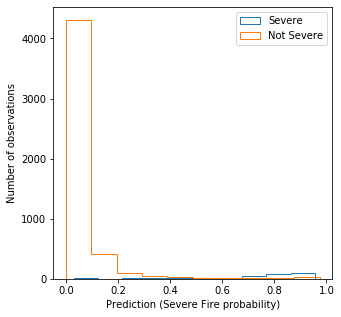

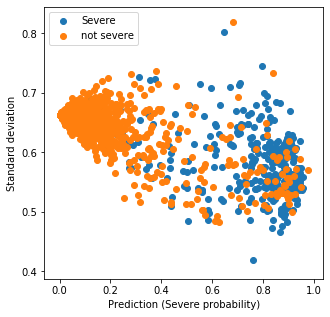

In [202]:
# Create a new RF model using the default parameters we used in class. Include probability to enable evaluation later. 
rf_clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                        criterion='gini', max_depth=20,
                                        max_features='log2',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=200, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False)
# fit using the scaled data set
fit = rf_clf.fit(X_p1_train, y_p1_train)

# Calculate the predictions
y_hat_rf = fit.predict_proba(X_p1_test)
idx_severe = np.where(y_p1_test == 1)[0]
idx_not_severe = np.where(y_p1_test == 0)[0]

# Histogram predictions without error bars:
fig, ax = plt.subplots(1)
ax.hist(y_hat_rf[idx_severe, 1], histtype='step', label='Severe')
ax.hist(y_hat_rf[idx_not_severe, 1], histtype='step', label='Not Severe')
ax.set_xlabel('Prediction (Severe Fire probability)')
ax.set_ylabel('Number of observations')
plt.legend()

# Calculate the variance
severe_V_IJ_unbiased = fci.random_forest_error(fit, X_p1_train, X_p1_test)

# Plot forest prediction for emails and standard deviation for estimates
# Blue points are spam emails; Green points are non-spam emails
fig, ax = plt.subplots(1)
ax.scatter(y_hat_rf[idx_severe, 1],
           np.sqrt(severe_V_IJ_unbiased[idx_severe]),
           label='Severe')

ax.scatter(y_hat_rf[idx_not_severe, 1],
           np.sqrt(severe_V_IJ_unbiased[idx_not_severe]),
           label='not severe')

ax.set_xlabel('Prediction (Severe probability)')
ax.set_ylabel('Standard deviation')
plt.legend()
plt.show()

In the first plot above, we can see the probability distribution of the observations in the predictions we are making. We can see the severe imbalance in the data set and that we are making some high probability predictions for the severe fire. We are also making some low probability predictions. 

This is further visible in the second plot, where we can see that while we are able to handle the primary clusters of severe vs. non-severe, there is still some significant overlap in our model where we predict with some high probability that a fire is incorrectly classified as severe. The good news is that it does not appear to be the majority and we've taken a significant step towards making correct predictions. 

Reference: http://contrib.scikit-learn.org/forest-confidence-interval/auto_examples/plot_spam.html#sphx-glr-auto-examples-plot-spam-py

# Problem 2: Linear Regression (test) 

Continuous ONly Train R2:  0.465693847873887
Continuous Only Test R2:  0.46070341364269485
All features Train R2:  0.6669654398922995
All features Test R2:  -1.604725794021336e+16
Removing Features Train R2:  0.6669654538620213
Removing Features Test R2:  -1.6047257940213344e+16


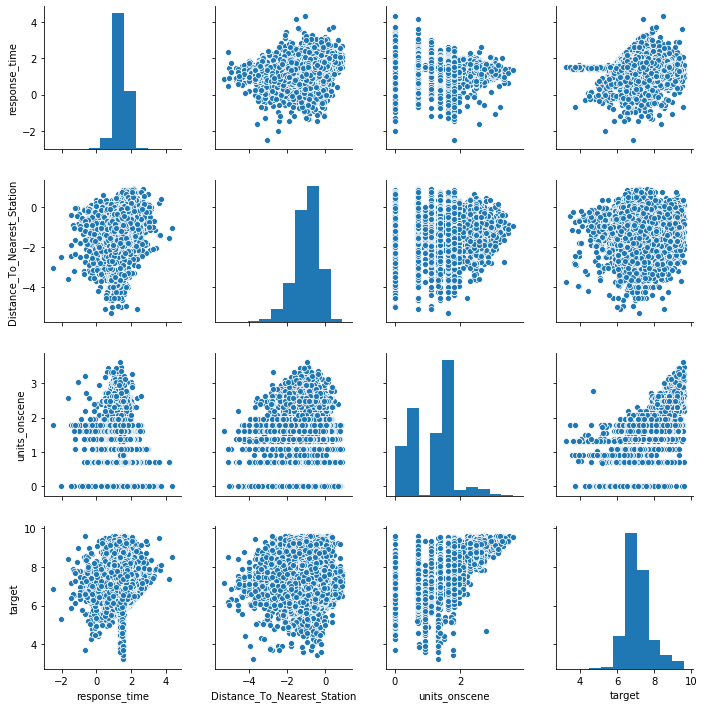

In [174]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#glm = LinearRegression()
#glm.fit(X_p2_train, y_p2_train)
#yhat = glm.predict(X_p2_test)

plot_df = pd.DataFrame(model_2_df, columns=['response_time','Distance_To_Nearest_Station','units_onscene','target'])
plot_df['response_time'] = np.log(plot_df['response_time'])
plot_df['target'] = np.log(plot_df['target'])
plot_df['Distance_To_Nearest_Station'] = np.log(plot_df['Distance_To_Nearest_Station'])
plot_df['units_onscene'] = np.log(plot_df['units_onscene'])
sns.pairplot(plot_df)

glm = LinearRegression()
model = glm.fit(X_p2_train[['response_time','Distance_To_Nearest_Station','units_onscene', 'borough_desc_2 - Bronx',	'borough_desc_4 - Brooklyn',	'borough_desc_3 - Staten Island',	'borough_desc_1 - Manhattan',	'borough_desc_5 - Queens']], y_p2_train)
yhat = model.predict(X_p2_test[['response_time','Distance_To_Nearest_Station','units_onscene', 'borough_desc_2 - Bronx',	'borough_desc_4 - Brooklyn',	'borough_desc_3 - Staten Island',	'borough_desc_1 - Manhattan',	'borough_desc_5 - Queens']])

print("Continuous ONly Train R2: ", model.score(X_p2_train[['response_time','Distance_To_Nearest_Station','units_onscene', 'borough_desc_2 - Bronx',	'borough_desc_4 - Brooklyn',	'borough_desc_3 - Staten Island',	'borough_desc_1 - Manhattan',	'borough_desc_5 - Queens']], y_p2_train))
print("Continuous Only Test R2: ", model.score(X_p2_test[['response_time','Distance_To_Nearest_Station','units_onscene', 'borough_desc_2 - Bronx',	'borough_desc_4 - Brooklyn',	'borough_desc_3 - Staten Island',	'borough_desc_1 - Manhattan',	'borough_desc_5 - Queens']], y_p2_test))

glm = LinearRegression()
model = glm.fit(X_p2_train, y_p2_train)
yhat = model.predict(X_p2_test)

print("All features Train R2: ", model.score(X_p2_train, y_p2_train))
print("All features Test R2: ", model.score(X_p2_test, y_p2_test))


X_p2_train.drop(columns = 'highest_level_desc_44 - Fourth Alarm', inplace = True)
X_p2_test.drop(columns = 'highest_level_desc_44 - Fourth Alarm', inplace = True)

glm = LinearRegression()
model = glm.fit(X_p2_train, y_p2_train)
yhat = model.predict(X_p2_test)

print("Removing Features Train R2: ", model.score(X_p2_train, y_p2_train))
print("Removing Features Test R2: ", model.score(X_p2_test, y_p2_test))
#glm = LinearRegression()
#model = glm.fit(np.log(X_p2_train[['response_time','Distance_To_Nearest_Station','units_onscene']]), np.log(y_p2_train))
#yhat = model.predict(np.log(X_p2_test[['response_time','Distance_To_Nearest_Station','units_onscene']]))

#print("Logged Train R2: ", model.score(np.log(X_p2_train[['response_time','Distance_To_Nearest_Station','units_onscene']]), np.log(y_p2_train)))
#print("Logged Test R2: ", model.score(np.log(X_p2_test[['response_time','Distance_To_Nearest_Station','units_onscene']]), np.log(y_p2_test)))

In [155]:
y_p2_test.min()

36.0

In [0]:
model_2_df = final_df

In [177]:
model_2_df.columns

Index(['action_taken1_desc', 'action_taken2_desc', 'action_taken3_desc',
       'aes_presence_desc', 'borough_desc', 'detector_presence_desc',
       'fire_box', 'highest_level_desc', 'im_incident_key',
       'incident_date_time', 'incident_type_desc',
       'last_unit_cleared_date_time', 'property_use_desc',
       'standpipe_sys_present_flag', 'street_highway', 'units_onscene',
       'zip_code', 'response_time', 'LONG', 'LAT', 'nearest_intersection',
       'incident_code', 'incident_desc', 'Distance_To_Nearest_Station', 'DATE',
       'PRCP', 'SNOW', 'SNWD', 'incident_month', 'FireLevel', 'target'],
      dtype='object')

In [195]:
from statsmodels.formula.api import ols


model = ols('target ~ C(aes_presence_desc) + C(detector_presence_desc) + C(action_taken1_desc) + C(incident_type_desc) + C(borough_desc) + C(property_use_desc) + C(highest_level_desc) + C(highest_level_desc)*units_onscene + C(property_use_desc)*units_onscene + units_onscene + response_time + Distance_To_Nearest_Station + SNWD + SNOW + PRCP + incident_month + C(aes_presence_desc) * response_time + Distance_To_Nearest_Station * C(borough_desc) + response_time * C(incident_type_desc)', data=model_2_df)
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     164.0
Date:                Fri, 25 Oct 2019   Prob (F-statistic):               0.00
Time:                        22:44:30   Log-Likelihood:            -2.1820e+05
No. Observations:               26166   AIC:                         4.371e+05
Df Residuals:                   25826   BIC:                         4.399e+05
Df Model:                         339                                         
Covariance Type:            nonrobust                                         
===================================================================================================================================================================
                                                                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                         728.8942    787.284      0.926      0.355    -814.227    2272.016
C(aes_presence_desc)[T.1]                                                                         979.0285    292.833      3.343      0.001     405.060    1552.997
C(detector_presence_desc)[T.1]                                                                   -257.3670     58.643     -4.389      0.000    -372.310    -142.424
C(action_taken1_desc)[T.10 - Fire control or extinguishment, other]                               191.0049    126.759      1.507      0.132     -57.451     439.461
C(action_taken1_desc)[T.11 - Extinguishment by fire service personnel]                            317.9353    123.357      2.577      0.010      76.149     559.722
C(action_taken1_desc)[T.111 - Hooked up to hydrant]                                               287.4431    154.221      1.864      0.062     -14.839     589.726
C(action_taken1_desc)[T.112 - Stretch 1 3/4" line, extinguish fire]                               848.9268    168.830      5.028      0.000     518.010    1179.844
C(action_taken1_desc)[T.113 - Stretch 2 1/2" line, extinguish fire]                              1336.5911    351.059      3.807      0.000     648.496    2024.686
C(action_taken1_desc)[T.115 - Stretched precautionary line stood fast]                            563.1013    223.636      2.518      0.012     124.762    1001.440
C(action_taken1_desc)[T.118 - Supplied Standpipe System]                                         -233.5605   1029.323     -0.227      0.820   -2251.091    1783.970
C(action_taken1_desc)[T.12 - Salvage & overhaul]                                                  196.5516    434.179      0.453      0.651    -654.463    1047.566
C(action_taken1_desc)[T.15 - Confine fire (wildland)]                                            -120.6417   1030.489     -0.117      0.907   -2140.459    1899.175
C(action_taken1_desc)[T.20 - Search & rescue, other]                                              944.9285   1134.227      0.833      0.405   -1278.220    3168.077
C(action_taken1_desc)[T.21 - Search]                                                              285.3381    147.185      1.939      0.053      -3.153     573.830
C(action_taken1_desc)[T.211 - Performed primary search, fire area]                                -88.7461    405.763     -0.219      0.827    -884.064     706.572
C(action_taken1_desc)[T.212 - Performed secondary search, fire area]                              550.4355    749.326      0.735   

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [0]:
rfr = RandomForestRegressor(n_estimators=100)
model2 = rfr.fit(X_p2_train, np.sqrt(y_p2_train))
yhat_rfr = model2.predict(X_p2_test)

In [237]:
print("RFR Train R2: ", model2.score(X_p2_train, np.sqrt(y_p2_train)))
print("RFR R2: ", model2.score(X_p2_test, np.sqrt(y_p2_test)))

RFR Train R2:  0.9471034069081701
RFR R2:  0.6189631230444047


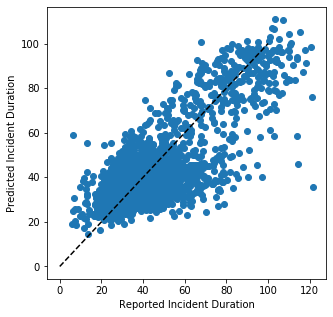

/usr/local/lib/python3.6/dist-packages/forestci/calibration.py:86: RuntimeWarning: overflow encountered in exp
  g_eta_raw = np.exp(np.dot(XX, eta)) * mask
/usr/local/lib/python3.6/dist-packages/forestci/calibration.py:102: RuntimeWarning: invalid value encountered in true_divide
  g_eta_main = g_eta_raw / sum(g_eta_raw)


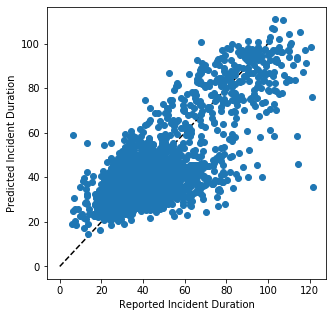

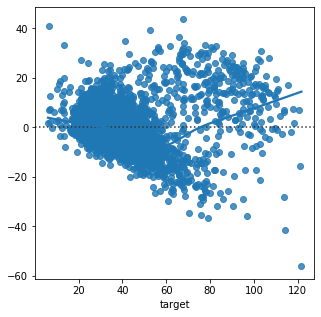

In [240]:
# Plot predicted MPG without error bars
plt.scatter(np.sqrt(y_p2_test), yhat_rfr)
plt.plot([0, 100], [0, 100], 'k--')
plt.xlabel('Reported Incident Duration')
plt.ylabel('Predicted Incident Duration')
plt.show()

# Calculate the variance:
duration_V_IJ_unbiased = fci.random_forest_error(model2, X_p2_train,X_p2_test)

# Plot error bars for predicted MPG using unbiased variance
plt.errorbar(np.sqrt(y_p2_test), yhat_rfr, yerr=np.sqrt(duration_V_IJ_unbiased), fmt='o')
plt.plot([0, 100], [0, 100], 'k--')
plt.xlabel('Reported Incident Duration')
plt.ylabel('Predicted Incident Duration')
plt.show()

sns.residplot(np.sqrt(y_p2_test), yhat_rfr, lowess = True)
plt.show()